<u><h1 style="text-align: center;">AAG - Méthodes Classiques en IA</h1>

## __Préparation du dataset & création des corpus__

__Dataset R6 :__
<style>
    .heatMap {
        width: 70%;
        text-align: center;
    }
    .heatMap th {
        background: grey;
        word-wrap: break-word;
        text-align: center;
    }

</style>

<ins>Types de features</ins>
<div class="heatMap">
									

|   Nom des features           |  Type       | description |
|:---------------:|:-----------:|:-----------:|
|   skillrank  |   Nom (string)   | rang du joueur |
|   operator  |   Nom (string)  | nom du personnage |
|   primaryweapon   |   Nom (string)   | nom de l'arme principale |
|   secondaryweapon   |   nom (string)   | nom de l'arme secondaire |
|   secondarygadget   |   nom (string)   | nom du gadget utilisé |
|   k/d   |   numeric (int)   | ratio mort/kill (1 si >1 sinon 0) |
|   target   |   numeric (int)   | ratio victoire/partie (1 si >50% sinon 0)
</div>

<ins>Séparation du corpus</ins>
<div class="heatMap">

|  target / corpus | Train (2/3) | Test(1/3) | Total / type de w/r |
|:---------------:|:-----:|:----:|:------:|
| 1 (w/r positif)  |   398  |  199  |   597   |
| 0 (w/r negatif) |   1035  |  518  |   1553   |
| Total / corpus |   1433 | 717  |  2150   |

</div>

on peut utiliser le naive bayes car nos descripteurs sont tous discrétisé / discrets

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from scipy.spatial import distance

In [2]:
def reset_dataset():
    global corpus_test_non_annot
    global corpus_train
    global corpus_verif
    global y_test
    # Chargement du dataset dans une DataFrame
    dataset_R6 = pd.read_csv("./DatasetR6/S5_operators.csv", sep=';')

    # on calcule le w/r
    dataset_R6.insert(dataset_R6.shape[1],"w/r", (dataset_R6["nbwins"]/dataset_R6["nbpicks"]), True) 
    dataset_R6.drop(columns=["nbwins","nbpicks","role"], inplace=True)

    # on calcule le k/d
    dataset_R6.loc[dataset_R6['nbdeaths'] == 0] = 1
    # on a une ligne qui fait que des 1 partout 
    dataset_R6.drop(axis=0, index=dataset_R6[dataset_R6['operator'] == 1].index, inplace=True)
    dataset_R6['k/d'] = dataset_R6['nbkills'] / dataset_R6['nbdeaths']


    # on merge et enleve les colonnes plateformes et dateid sans perdre les données associées
    dataset_R6 = dataset_R6.groupby(['skillrank','operator', 'primaryweapon', 'secondaryweapon', 'secondarygadget'], as_index=False)[['w/r', 'k/d']].mean()

    # discretisation de w/r
    dataset_R6.insert(dataset_R6.shape[1],"target", (dataset_R6["w/r"]>=0.5).astype(int), True) 

    dataset_R6.drop(columns=["w/r"], inplace=True)

    #discrétisation de k/d
    dataset_R6['k/d'] = (dataset_R6["k/d"]>=1.0).astype(int)


    # changement de la taille d'affichage des dataframes
    #pd.set_option('display.max_rows', dataset_R6.shape[0]+1)


    # création des corpus annotés et non annotés
    corpus_annot = dataset_R6.copy()
    corpus_annot = corpus_annot[['target']]

    corpus_non_annot = dataset_R6.copy()
    corpus_non_annot.drop(columns=["target"], inplace=True)

    x_train, x_test, y_train, y_test = train_test_split(corpus_non_annot, corpus_annot, test_size=1/3, random_state=42, stratify=corpus_annot)

    corpus_test_non_annot = x_test.copy()

    corpus_train = x_train.copy()
    corpus_train['target'] = y_train.copy()

    corpus_verif = x_test.copy()
    corpus_verif['target'] = y_test.copy()

reset_dataset()
print('affichage du corpus test avec annotations')
corpus_verif.head(10)


affichage du corpus test avec annotations


,skillrank,operator,primaryweapon,secondaryweapon,secondarygadget,k/d,target
583,Copper,SWAT-PULSE,M1014,M45 MEUSOC,NITRO CELL,0,0
962,Gold,GIGN-RESERVE,F2,LFP586,FRAG GRENADE,0,0
992,Gold,GIGN-ROOK,P90,P9,DEPLOYABLE SHIELD,0,1
1612,Silver,GIGN-ROOK,SG-CQB,P9,DEPLOYABLE SHIELD,0,1
368,Copper,GIGN-RESERVE,SG-CQB,LFP586,DEPLOYABLE SHIELD,0,0
211,Bronze,SPETSNAZ-FUZE,AK-12,PMM,STUN GRENADE,1,0
1199,Gold,SWAT-RESERVE,556XI,5.7 USG,STUN GRENADE,0,0
2122,Unranked,SWAT-RESERVE,556XI,5.7 USG,FRAG GRENADE,0,0
1997,Unranked,SAS-RESERVE,M590A1,P226 MK 25,FRAG GRENADE,0,0
43,Bronze,GIGN-MONTAGNE,Shield,P9,STUN GRENADE,0,0


Petite fonction pour avoir l'accuracy 

In [28]:
def tester_accuracy(corpus_train, corpus_non_annote, modele_hyp):
    # on fait l'hypothese et on compare avec le corpus de verification
    nb_true, nb_false  = modele_hyp(corpus_train, corpus_non_annote).eq(corpus_verif)['target'].value_counts()
    accuracy = (nb_true/(nb_true+nb_false))
    print(f' nous avons {nb_true} bonnes annotations et {nb_false} mauvaises annotations sur {nb_true+nb_false} données ce qui donne un accuracy de {accuracy}\n')
    return accuracy


## __Partie supervisée__

### ZeroR

In [29]:
def classe_plus_commune(corp_annote):
    # creation d'un tableau de taille du nombre de classe
    a = [0] * corp_annote.target.nunique()
    # on compte le nombre d'occurence de chaque classe
    for x in corp_annote.itertuples():
        a[x.target] += 1
    return a.index(max(a))

def zeror_hyp(corpus_train, corp_non_annote):
    classe_moyenne = classe_plus_commune(corpus_train)
    corp_non_annote['target'] = classe_moyenne
    return corp_non_annote

accu_zeror = tester_accuracy(corpus_train, corpus_test_non_annot, zeror_hyp)

 nous avons 518 bonnes annotations et 199 mauvaises annotations sur 717 données ce qui donne un accuracy de 0.7224546722454672



### OneR

In [30]:
reset_dataset()

'''
Trouve le descripteur qui minimise le taux d'erreur et annote le corpus passé en paramètre
'''
def oneR_hyp(corp_train, corp_non_annote):

    meilleur_attribut = ''
    meilleur_attribut_cer = 1
    dic_att = {}
    
    if('target' in corp_non_annote.columns):
        corp_non_annote.drop(columns=["target"], inplace=True)
    
    # Recherche du descripteur qui minimise le taux d'erreur
    for nom_attribut in corp_non_annote.columns:
        attribut = corp_non_annote[nom_attribut]
        tab_val = []
        for valeur in attribut.unique():
            #print(f"pour la valeur {valeur} la target max est \n {corp_train.loc[corp_train[nom_attribut] == valeur]['target'].value_counts().idxmax()}")
            dic_att[valeur] = corp_train.loc[corp_train[nom_attribut] == valeur]['target'].value_counts().idxmax()
        target_hyp = corp_non_annote[nom_attribut].map(dic_att)
        
        salut = corp_non_annote.copy()
        salut['target'] = target_hyp
        cer = calcul_cer(salut, salut['target'].eq(corpus_verif['target']).value_counts(), nom_attribut)
        print(f" l'attribut {nom_attribut} a un CER de {cer}")
        if(cer < meilleur_attribut_cer):
            meilleur_attribut = nom_attribut
            meilleur_attribut_cer = cer
    
    print(f"\nL'attribut avec le CER le plus petit est {nom_attribut} avec un CER de {cer}\n")
    corp_non_annote['target'] = corp_non_annote[meilleur_attribut]
    #print(dic_att)
    return corp_non_annote


'''
Calcul le taux d'erreur de la classification

Rappel :
Cer = (# instances mal classées) / (# instances classées)
'''
def calcul_cer(corp_verif, tab_vrai_faux, nom_descripteur):
    # on fait l'hypothese et on compare avec le corpus de verification
    if(tab_vrai_faux.size > 1):
        nb_true = tab_vrai_faux[True]
        nb_false = tab_vrai_faux[False]
    else:
        nb_true = tab_vrai_faux[0]
        nb_false = 0
    #print(f' pour le descripteur {nom_descripteur}, nous avons {nb_true} bonnes annotations et {nb_false} mauvaises annotations sur {nb_true+nb_false} données ce qui donne un taux d\'erreur de {(nb_false/(nb_true+nb_false))*100}%')
    return nb_false/(nb_true+nb_false)
    
accu_oner = tester_accuracy(corpus_train, corpus_test_non_annot, oneR_hyp)

 l'attribut skillrank a un CER de 0.2775453277545328
 l'attribut operator a un CER de 0.2412831241283124
 l'attribut primaryweapon a un CER de 0.2482566248256625
 l'attribut secondaryweapon a un CER de 0.28730822873082285
 l'attribut secondarygadget a un CER de 0.28312412831241285
 l'attribut k/d a un CER de 0.16596931659693165

L'attribut avec le CER le plus petit est k/d avec un CER de 0.16596931659693165

 nous avons 598 bonnes annotations et 119 mauvaises annotations sur 717 données ce qui donne un accuracy de 0.8340306834030683



### KPPV

In [11]:
reset_dataset()

'''
fonction qui calcule la distance de hamming entre deux vecteurs

'''
def hamming(x, y):
    cpt = 0
    #print(x, y)
    for i in range(0, len(y)-1):
        if x[i] != y[i]:
            cpt += 1
    return cpt


'''
fonction qui réalise l'alogrithme des k plus proches voisins pour un corpus de test

'''
def kppv_hyp_row(corpus_train,corpus_test, k):
    nouveau_corpus = corpus_test.copy()
    for row in corpus_test.itertuples():
        matrice_distance = []
        for row2 in corpus_train.itertuples():
            matrice_distance.append(hamming(row, row2))
                
        matrice_des_indices_des_elements_les_plus_proches = []
        #print(matrice_distance)

        for i in range(0, k):
            matrice_des_indices_des_elements_les_plus_proches.append(matrice_distance.index(min(matrice_distance)))
            matrice_distance[matrice_distance.index(min(matrice_distance))] = 1000

        cpt_0 = 0
        cpt_1 = 0
        #print(matrice_des_indices_des_elements_les_plus_proches)
        
        for i in matrice_des_indices_des_elements_les_plus_proches:
            #print(i,corpus_train.iloc[i]['target'])
            if corpus_train.iloc[i]['target'] == 1:
                cpt_1 += 1
            else:
                cpt_0 += 1
        
        if cpt_1 > cpt_0:
            nouveau_corpus.at[row.Index, 'target'] = 1
        else:
            nouveau_corpus.at[row.Index, 'target'] = 0

    return nouveau_corpus

In [37]:
corpus_train2 = corpus_train.head(10)
corpus_test = corpus_test_non_annot.head(30)

a = kppv_hyp_row(corpus_train,corpus_test_non_annot, 3)
print(a)

nb_true, nb_false  = kppv_hyp_row(corpus_train,corpus_test_non_annot, 3).eq(corpus_verif)['target'].value_counts()
accu_kppv = (nb_true/(nb_true+nb_false))
print(f'Nous avons {nb_true} bonnes annotations et {nb_false} mauvaises annotations sur {nb_true+nb_false} données ce qui donne un accuracy de {accu_kppv}%')

     skillrank             operator   primaryweapon secondaryweapon  \
583     Copper           SWAT-PULSE           M1014      M45 MEUSOC   
962       Gold         GIGN-RESERVE              F2          LFP586   
992       Gold            GIGN-ROOK             P90              P9   
1612    Silver            GIGN-ROOK          SG-CQB              P9   
368     Copper         GIGN-RESERVE          SG-CQB          LFP586   
211     Bronze        SPETSNAZ-FUZE           AK-12             PMM   
1199      Gold         SWAT-RESERVE           556XI         5.7 USG   
2122  Unranked         SWAT-RESERVE           556XI         5.7 USG   
1997  Unranked          SAS-RESERVE          M590A1      P226 MK 25   
43      Bronze        GIGN-MONTAGNE          Shield              P9   
1982  Unranked             SAS-MUTE            MP5K      P226 MK 25   
1146      Gold     SPETSNAZ-RESERVE            6P41          GSH-18   
767    Diamond          SAS-RESERVE          M590A1      P226 MK 25   
959   

### Naive Bayes

#### Préparation de vraisemblance / proba à priori

In [33]:
reset_dataset()

def calcul_vraisemblance(nom_attribut, valeur_attribut, valeur_target):
    corpus_vraisemblance = corpus_verif.copy().groupby([nom_attribut,'target'], as_index=False).size()
    #nombre de fois que l'attribut apparait dans le corpus avec ce target
    nb_val_targ = corpus_vraisemblance[(corpus_vraisemblance[nom_attribut] == valeur_attribut) & (corpus_vraisemblance['target'] == valeur_target)]['size'].sum()
    
    #nombre de fois que ce target apparait dans le corpus
    nb_val_total = corpus_vraisemblance[corpus_vraisemblance['target'] == valeur_target]['size'].sum()
    return  nb_val_targ / nb_val_total

def calcul_a_priori(valeur_target):
    corpus_a_priori = corpus_verif.copy().groupby(['target'], as_index=False).size()
    nb_target = corpus_a_priori[corpus_a_priori['target'] == valeur_target]['size'].sum()
    nb_autre = corpus_a_priori[corpus_a_priori['target'] != valeur_target]['size'].sum()
    return nb_target / (nb_autre + nb_target)

print(calcul_vraisemblance('skillrank', 'Bronze', 0))
calcul_a_priori(0)

0.138996138996139


0.7224546722454672

#### On va construire un dictionaire des vraisemblance avec le corpus d'entraînement

In [34]:
def train_naive_bayes(df_train):
    dict_vraisemblance = {}

    for nom_attribut in df_train:
        if(nom_attribut != 'target'):
            dict_vraisemblance[nom_attribut] = {}
            for valeurs in df_train[nom_attribut].unique():
                dict_vraisemblance[nom_attribut][valeurs] = {}
                for classe in df_train['target'].unique():
                    dict_vraisemblance[nom_attribut][valeurs][classe] = calcul_vraisemblance(nom_attribut, valeurs, classe)
                    
    return dict_vraisemblance

dict_vrais = train_naive_bayes(corpus_train)
dict_vrais

{'skillrank': {'Bronze': {0: 0.138996138996139, 1: 0.1306532663316583},
  'Platinum': {0: 0.12162162162162163, 1: 0.24623115577889448},
  'Unranked': {0: 0.21428571428571427, 1: 0.005025125628140704},
  'Silver': {0: 0.13320463320463322, 1: 0.1658291457286432},
  'Diamond': {0: 0.09266409266409266, 1: 0.20603015075376885},
  'Copper': {0: 0.16988416988416988, 1: 0.04020100502512563},
  'Gold': {0: 0.12934362934362933, 1: 0.20603015075376885}},
 'operator': {'GIGN-DOC': {0: 0.032818532818532815, 1: 0.06030150753768844},
  'SAT-ECHO': {0: 0.013513513513513514, 1: 0.035175879396984924},
  'SPETSNAZ-RESERVE': {0: 0.08494208494208494, 1: 0.01507537688442211},
  'GIGN-RESERVE': {0: 0.10617760617760617, 1: 0.005025125628140704},
  'SWAT-PULSE': {0: 0.02895752895752896, 1: 0.06532663316582915},
  'SWAT-RESERVE': {0: 0.08301158301158301, 1: 0.005025125628140704},
  'JTF2-BUCK': {0: 0.023166023166023165, 1: 0.005025125628140704},
  'SPETSNAZ-FUZE': {0: 0.04633204633204633, 1: 0.05025125628140704

In [35]:
'''
Fontion qui réalise l'alogrithme Naive Bayes pour une ligne de données
'''
def hypothese_naive_bayes_serie(data, dict_vraisemblance):
    meilleur_proba = -1
    meilleur_target = -1
    for target in range(0,2):
        proba_posteriori = np.longdouble(1)
        
        for nom_attribut in data.keys():
            proba_posteriori *= dict_vraisemblance[nom_attribut][data[nom_attribut]][target]
        proba_posteriori *= calcul_a_priori(target)
        
        if(proba_posteriori > meilleur_proba):
            meilleur_proba = proba_posteriori
            meilleur_target = target
            
    return meilleur_target

print(f'hypothèse sur serie : {hypothese_naive_bayes_serie(corpus_test_non_annot.iloc[20], dict_vrais)}\n')

pd.set_option('display.max_rows', corpus_test_non_annot.shape[0]+1)

'''
Fonction qui réalise l'alogrithme Naive Bayes pour un corpus de test
'''
def hypothese_naive_bayes(corpus_test, dict_vraisemblance):
    #copie pour éviter d'étiqueter le dataframe original
    copie_df = corpus_test.copy()
    target = []
    
    for _, row in copie_df.iterrows():
        target.append(hypothese_naive_bayes_serie(row, dict_vraisemblance))
        
    # étiquetage du dataframe
    copie_df['target'] = target
    return copie_df
  
print(f"nombre de 1 et 0 de l'hypothèse sur corpus : \n{ hypothese_naive_bayes(corpus_test_non_annot, dict_vrais).groupby(['target'], as_index=False).size() }")
accu_naive_bayes = tester_accuracy(corpus_test_non_annot, dict_vrais, hypothese_naive_bayes)

hypothèse sur serie : 1

nombre de 1 et 0 de l'hypothèse sur corpus : 
   target  size
0       0   523
1       1   194
 nous avons 630 bonnes annotations et 87 mauvaises annotations sur 717 données ce qui donne un accuracy de 0.8786610878661087



## __Partie non supervisée__

### K-Means

In [ ]:
# Chargement du dataset dans une DataFrame
dataset_R6 = pd.read_csv("./DatasetR6/S5_operators.csv", sep=';')

# plus de lose rate
dataset_R6.insert(dataset_R6.shape[1],"w/r", (dataset_R6["nbwins"]/dataset_R6["nbpicks"]), True) 
dataset_R6.insert(dataset_R6.shape[1],"k/r", (dataset_R6["nbkills"]/dataset_R6["nbpicks"]), True) 
dataset_R6.insert(dataset_R6.shape[1],"d/r", (1-(dataset_R6["nbdeaths"]/dataset_R6["nbpicks"])), True) 
dataset_R6.drop(columns=["nbwins","nbpicks","role"], inplace=True)


# on merge et enleve les colonnes plateformes et dateid sans perdre les données associées
dataset_R6 = dataset_R6.groupby(['skillrank','operator', 'primaryweapon', 'secondaryweapon', 'secondarygadget'], as_index=False)[['w/r','k/r','d/r']].mean()
dataset_R6.drop(columns=['skillrank','operator', 'primaryweapon', 'secondaryweapon', 'secondarygadget'], inplace=True)

data = dataset_R6.copy()

def nombre_aleatoire(minimum, maximum):
    return random.uniform(minimum, maximum)

dataset = data.copy()
print(data.shape)

(2151, 3)


In [ ]:
def intit_centroide(data, k):
    tab_centroide = []
    for j in range(0, k):
        tab_coord_centroide = []
        for i in range(0, data.shape[1]):
            mu = data.iloc[:, i].mean()
            min = data.iloc[:, i].min()
            max = data.iloc[:, i].max()
            tab_coord_centroide.append(nombre_aleatoire(min, max))
        #print(tab_coord_centroide)
        tab_centroide.append(tab_coord_centroide)
    return np.array(tab_centroide).reshape(-1, 3)

#matrice_centroide = intit_centroide(data, 3)
#print("La matrice avant est \n",matrice_centroide)
#print(matrice_centroide.shape[0])

In [ ]:
# Liste des centroide les plus proches de chaque point
def fonc_liste_centroide_le_plus_proche(data, matrice_centroide):
    liste_centroide_le_plus_proche = []
    for i in range(0, data.shape[0]):
        distance_plus_proche = distance.euclidean(data.iloc[i], matrice_centroide[0])
        centroide_le_plus_proche = 0
        for j in range(1, matrice_centroide.shape[0]):
            if distance.euclidean(data.iloc[i], matrice_centroide[j]) < distance_plus_proche:
                distance_plus_proche = distance.euclidean(data.iloc[i], matrice_centroide[j])
                centroide_le_plus_proche = j
        liste_centroide_le_plus_proche.append(centroide_le_plus_proche)
    return liste_centroide_le_plus_proche

#liste_centroide_le_plus_proche = fonc_liste_centroide_le_plus_proche(data, matrice_centroide)
#print("La liste des centroide les plus proches est \n",liste_centroide_le_plus_proche)

In [ ]:
def K_Means(data, k, nb_tour=100):
    matrice_centroide = intit_centroide(data, k)

    # Calcule la moyenne des points liés aux centroides
    length, width = matrice_centroide.shape
    liste_centroide_le_plus_proche = fonc_liste_centroide_le_plus_proche(data, matrice_centroide)
    ##print("la matrice est \n",matrice_centroide.shape)
    nb_centroide = 1
    mat2 = []
    cpt = 0
    #print("matrice avant func :\n",matrice_centroide)
    while((np.array_equal(matrice_centroide, mat2) == False) and (cpt < nb_tour)):
        cpt += 1
        mat2 = matrice_centroide.copy()
        for i in range(0,length):
            for j in range(0, len(liste_centroide_le_plus_proche)):
                if(liste_centroide_le_plus_proche[j]==i):
                    nb_centroide += 1
                    matrice_centroide[i] += data.iloc[j]
            matrice_centroide[i] = matrice_centroide[i]/nb_centroide
            nb_centroide = 1
        #print("matrice mat2 :\n",mat2)
        #print("matrice complete :\n",matrice_centroide)
        liste_centroide_le_plus_proche = fonc_liste_centroide_le_plus_proche(data, matrice_centroide)
        #if(cpt%10 == 0):
        #    print("Nombre de tour =",cpt)

    print("Nombre de tour =",cpt)
    return liste_centroide_le_plus_proche, matrice_centroide

#liste_centroide_le_plus_proche,matrice_centroide = K_Means(data, k=3)

Nombre de tour = 20


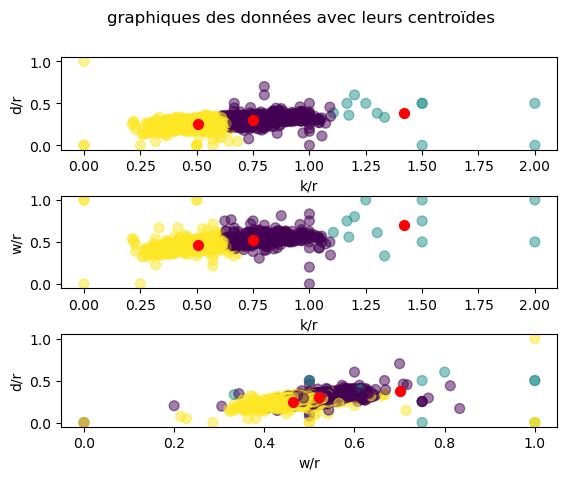

In [ ]:
liste_centroide_le_plus_proche,centroids = K_Means(data, k=3)

fig, axs = plt.subplots(3)
fig.suptitle('graphiques des données avec leurs centroïdes')

axs[0].scatter(dataset['k/r'], dataset['d/r'],c=liste_centroide_le_plus_proche, s=50, alpha=0.5)  
axs[0].scatter(centroids[:, 1], centroids[:, 2], c='red', s=50)
axs[0].set(xlabel = 'k/r', ylabel ='d/r')

axs[1].scatter(dataset['k/r'], dataset['w/r'],c=liste_centroide_le_plus_proche, s=50, alpha=0.5)  
axs[1].scatter(centroids[:, 1], centroids[:, 0], c='red', s=50)
axs[1].set(xlabel = 'k/r', ylabel ='w/r')

axs[2].scatter(dataset['w/r'], dataset['d/r'],c=liste_centroide_le_plus_proche, s=50, alpha=0.5)  
axs[2].scatter(centroids[:, 0], centroids[:, 2], c='red', s=50)
axs[2].set(xlabel = 'w/r', ylabel ='d/r')

plt.subplots_adjust(hspace=0.5)

In [ ]:
#calcul de l'inertie
def calculate_inertia(data, k):
    liste_centroide_le_plus_proche, matrice_centroide = K_Means(data, k)
    inertia = 0
    for i in range(0, data.shape[0]):
        inertia += distance.euclidean(data.iloc[i], matrice_centroide[liste_centroide_le_plus_proche[i]])
    return inertia

#print("L'inertie est de : ",calculate_inertia(data, 3))

Nombre de tour = 20
L'inertie est de :  209.63061798984768


Nombre de tour = 7
tour : 1
Nombre de tour = 24
tour : 2
Nombre de tour = 21
tour : 3
Nombre de tour = 42
tour : 4
Nombre de tour = 32
tour : 5
Nombre de tour = 100
tour : 6
Nombre de tour = 100
tour : 7
Nombre de tour = 100
tour : 8
Nombre de tour = 100
tour : 9
[309.009571239597, 215.91763833724954, 209.63061798984768, 169.94109557362034, 168.58649497878542, 167.465753730514, 166.67044372453825, 135.6833533322288, 134.8305751221983]


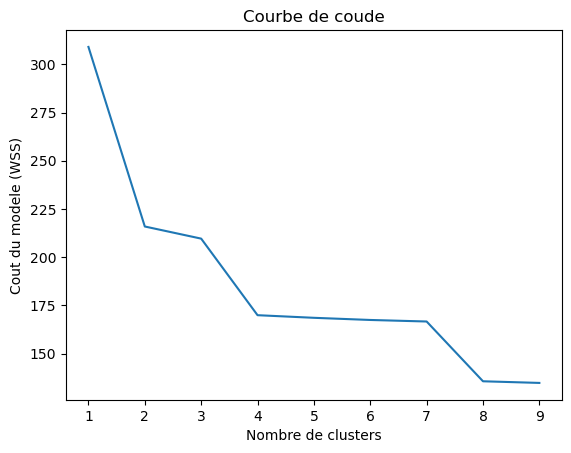

In [ ]:
#affichage de la courbe de coude
inertia = []
for k in range(1, 10):
    inertia.append(calculate_inertia(data, k))
    print("tour :",k)
print(inertia)
plt.plot(range(1, 10), inertia)
plt.title('Courbe de coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Cout du modele (WSS)')
plt.show()


### HAC

In [ ]:
from sklearn.cluster import AgglomerativeClustering

#on récupère les mêmes datas que pour le K-mean
dataset_test = dataset_R6.copy()
clusterings = []
for i in range(6) :
    clusterings.append(AgglomerativeClustering(n_clusters=i+1).fit(dataset_test))
#dataset_test.shape

In [ ]:
fig, axs = plt.subplots(2)


axs[0].scatter(dataset_test['w/r'], dataset_test['k/r'],c=clusterings[3].labels_.astype(float), s=50, alpha=0.5)  
axs[0].set_xlabel('nombre de kills')
axs[0].set_ylabel('nombre de death')

axs[1].scatter(dataset_test['w/r'], dataset_test['k/r'],c=clusterings[3].labels_.astype(float), s=50, alpha=0.5)
axs[1].set_xlabel('nombre de victoire')
axs[1].set_ylabel('nombre de partie joué')


fig.subplots_adjust(hspace=0.5)  # Ajustez la valeur selon vos besoins

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette = []

for i in range(1,6):
    silhouette.append(silhouette_score(dataset_test,clusterings[i].labels_))

plt.plot(range(1, 6), silhouette)
plt.title('Courbe de coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Cout du modele')
plt.show()

## __Analyse des résultats__

 l'attribut skillrank a un CER de 0.2775453277545328
 l'attribut operator a un CER de 0.2412831241283124
 l'attribut primaryweapon a un CER de 0.2482566248256625
 l'attribut secondaryweapon a un CER de 0.28730822873082285
 l'attribut secondarygadget a un CER de 0.28312412831241285
 l'attribut k/d a un CER de 0.16596931659693165

L'attribut avec le CER le plus petit est k/d avec un CER de 0.16596931659693165



(0.0, 1.0)

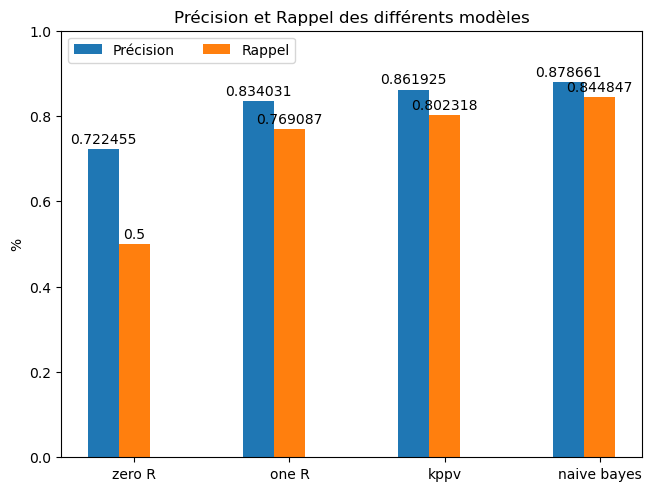

In [38]:
from sklearn.metrics import recall_score

dict_accu = {
    'zero R':accu_zeror,
    'one R':accu_oner,
    'kppv':accu_kppv,
    'naive bayes':accu_naive_bayes
}


rappel_zeror = recall_score(y_test, zeror_hyp(corpus_train, corpus_test_non_annot)['target'], average='macro')
reset_dataset()
rappel_oner = recall_score(y_test, oneR_hyp(corpus_train, corpus_test_non_annot)['target'], average='macro')
reset_dataset()
rappel_kppv = recall_score(y_test, kppv_hyp_row(corpus_train, corpus_test_non_annot,3)['target'], average='macro')
reset_dataset()
rappel_naive_bayes = recall_score(y_test, hypothese_naive_bayes(corpus_test_non_annot, dict_vrais)['target'], average='macro')

valeurs_eval = {
    'Précision': (accu_zeror, accu_oner, accu_kppv, accu_naive_bayes),
    'Rappel': (rappel_zeror, rappel_oner, rappel_kppv, rappel_naive_bayes),
}

eval = dict_accu.keys()

x = np.arange(len(eval))
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in valeurs_eval.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=2)
    multiplier += 1
    
ax.set_ylabel('%')
ax.set_title('Précision et Rappel des différents modèles')
ax.set_xticks(x + width, eval)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1)

In [ ]:
test